<a href="https://colab.research.google.com/github/wrymp/ML_ASS_4/blob/main/Animal_Faces_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initializations and Dataset Download

In [314]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [315]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [316]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [317]:
! chmod 600 ~/.kaggle/kaggle.json

In [318]:
# ! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [319]:
# ! unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

# 1,5. Adding WAND

In [320]:
!pip install wandb -qU

In [321]:
import wandb
import random
import math

In [322]:
wandb.login()

True

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [323]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


# 3. Reading Data Paths

The following code will be going through a nested directory structure where images are stored within subdirectories, each directory is representing a specific label (category). It constructs a list of the file paths for these images and their corresponding labels. Then, it creates a pandas DataFrame containing this information, which is useful for further data processing. Keep in mind that we will read all the data and then we will split it again to train, validation and testing.

In [324]:
data_df = pd.read_csv("/content/train.csv")
data_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# 4. Data Split
Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using `data_df.sample(frac=0.7,random_state=7)` then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using `data_df.drop(train.index)`. Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:



*   Training: 70%
*   Validation: 15%
*   Testing: 15%

In [325]:
train=data_df.sample(frac=0.8,random_state=42) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=42) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

# 6. Custom Dataset Class
Lets create a dataset class. Our class is a customized class on how we can our own dataset. The class inherits from the main `Dataset` class from PyTorch, then we overwrite some of the existing functions in that class. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main Dataset class with the concept of inheritance as mentioned. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the constructor function `__init__` we are declaring and our dataframe which will have `image_path` and the `labels`. Then we are creating our own image preprocessing object which is `transform` that we talked about before. For our labels, we are declaring our labels with the label_encoder we declared before. Which means that we will convert our labels are changed from string to numeric classes using `fit_tranform`. We didn't read each image inside the constructor as reading images here will be so time consuming. However, we are reading each image, applying the preprocessing and returning it in the `__getitem__` to read this specific image with its corresponding encoded label by their index and returns them.

In [326]:
class ExpressionDataset(Dataset):
    def __init__(self, dataframe):
        df = dataframe
        self.labels = df.iloc[:, 0].values
        self.images = df.iloc[:, 1].apply(lambda x: np.fromstring(x, sep=' '))
        H, W = 48, 48

        # Maybe you used different normalization?
        self.images = np.stack(self.images).astype(np.float32)

        # Option A: Standard normalization
        self.images = (self.images - 127.5) / 127.5  # [-1, 1] range

        # Option B: Z-score normalization
        # mean = self.images.mean()
        # std = self.images.std()
        # self.images = (self.images - mean) / std

        self.images = self.images.reshape(-1, 1, H, W)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]), torch.tensor(self.labels[idx])

# 7. Create Dataset Objects
Now lets create 3 data objects, for training data, validation and testing respectively giving them our dataframes we created before together with the `transform` object that we created before. We will use the same `transform` object to make sure all images are preprocessed as they are.

In [327]:
train_dataset = ExpressionDataset(dataframe=train)
val_dataset = ExpressionDataset(dataframe=val)
test_dataset = ExpressionDataset(dataframe=test)

# 9. Hyperparameters
Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs and learning rate.

In [328]:
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 30
DROPOUT_RATE = 0.4

# 10. DataLoaders
PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the `shuffle` to randomize the data and then you can loop through it in each epoch to train normally.

In [329]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#11. Model
Now we will build our CNN Network. We will be building it by creating a class that inherits from `nn.Module` and we will create our layers. Additionally, we will overwrite the `forward` function to modify our forward propagation.
The model will start by having a 2-d convolution neural network that will have input channels of 3 which is the RGB input channels. Outputting 32 feature map. Then another 2-d convolution neural network taking 32 channels and outputting 64 and finally another one taking 64 channels and outputting 128 feature map.
Each 2-d convolution neural network will be followed by a max pooling layer of size 2x2 and a `ReLU` activation function.

After that we will have a `flatten` layer to vectorize these feature maps followed by a linear layer which will have shape of (128, 16, 16) which means 128 feature map each one is 16x16 as the image started by 128x128 and got divided by 2 three times after each pooling layers. finally we will have an output `linear` layer with the length of the unique values of the labels.

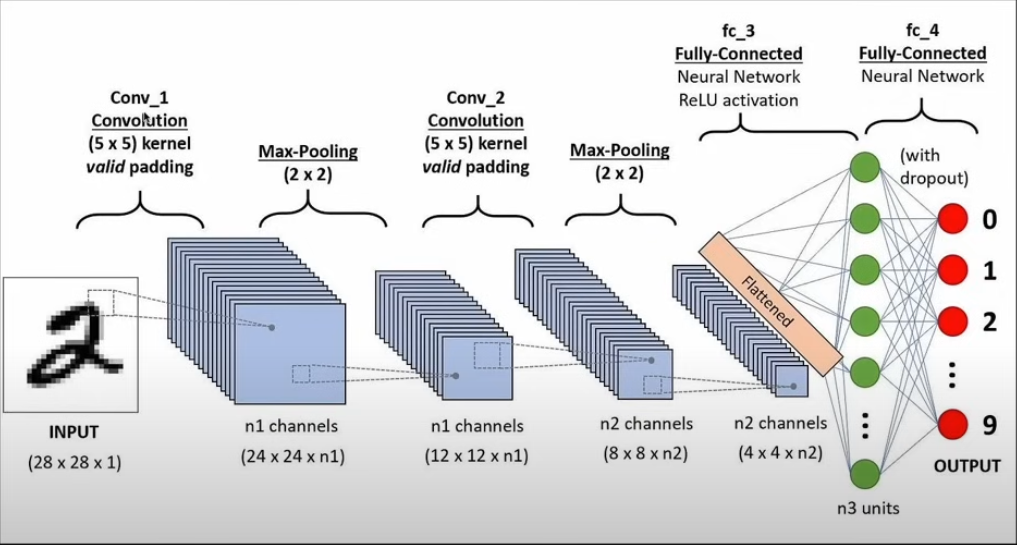

In [330]:
class Net(nn.Module):
    def __init__(self, num_classes, dropout_rate=DROPOUT_RATE):  # Lower dropout
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()

        # Maybe you changed this linear layer size?
        self.linear = nn.Linear(256 * 3 * 3, 512)  # Bigger hidden layer
        self.linear2 = nn.Linear(512, 256)  # Added another layer
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.pooling(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.relu(self.pooling(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.relu(self.pooling(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.relu(self.pooling(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))  # Added layer
        x = self.dropout(x)
        x = self.output(x)
        return x

# Usage
model = Net(num_classes=len(data_df['emotion'].unique())).to(device)


# 12. Model Summary
This cell is optional, here we show only the summary of the model and what is the output size for each layer. keep in mind that -1 here will be replaced by the batch size.


In [331]:
from torchsummary import summary
summary(model, input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         MaxPool2d-3           [-1, 32, 24, 24]               0
              ReLU-4           [-1, 32, 24, 24]               0
           Dropout-5           [-1, 32, 24, 24]               0
            Conv2d-6           [-1, 64, 24, 24]          18,496
       BatchNorm2d-7           [-1, 64, 24, 24]             128
         MaxPool2d-8           [-1, 64, 12, 12]               0
              ReLU-9           [-1, 64, 12, 12]               0
          Dropout-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 128, 12, 12]          73,856
      BatchNorm2d-12          [-1, 128, 12, 12]             256
        MaxPool2d-13            [-1, 128, 6, 6]               0
             ReLU-14            [-1, 12

# 13. Loss and Optimizer
In the cell below, we will create the loss function which will be the Cross Entropy loss. Also we will have create the Adam optimizer and we will provide to it the parameters of the model we created.

In [332]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

# 14. Training
Now comes the training part. If you know well the training process of deep learning. You will just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs which we defined before. But before that we define 4 lists and inside the loop we define another 4 variables.

## Variables:
* `total_acc_train`: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

* `total_loss_train`: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

* `total_acc_val`: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

* `total_loss_val`: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

## Lists:
* `total_acc_train_plot`: We append the losses of the training accuracy to visualize them at the end.

* `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

* `total_acc_validation_plot`: We append the losses of the validation accuracy to visualize them at the end.

* `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.


Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We add the loss amount to `total_loss_train`. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the `total_acc_train`. Then we do the `batch_loss.backward()` which makes the backpropagation and we use the optimizer to do a step on the weights using `optimizer.step()` and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step that has to be done before proceeding.

After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with `torch.no_grad()` so that we freeze the weights, which means that we need the model to do predicitons **without being trained**. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. Accuracies are calculated by dividing the right predictions by the complete number of samples and multiplying by 100. Losses are being divided by 1000 just to normalize the values and avoid large values.



In [333]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  wandb.init(
    project="TrainingHumanEmotionDetector_"+optimizer.__class__.__name__,
    name=f"epoch_{epoch}",
    config={
    "LR": LR,
    "batchSize": BATCH_SIZE,
    "epochs": EPOCHS,
    "architecture": "CNN",
    "optimizer": optimizer.__class__.__name__,
    "criterion": criterion.__class__.__name__,
    "dropout_rate": DROPOUT_RATE,
    })
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    outputs = model(inputs)
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc
      # scheduler.step(val_acc)

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  wandb.log({"Train Accuracy": round((total_acc_train)/train_dataset.__len__() * 100, 4),
             "Train_Loss": round(total_loss_train/100, 4),
             "Validation_Loss": round(total_loss_val/100, 4),
             "Validation Accuracy": round((total_acc_val)/val_dataset.__len__() * 100, 4),
              "dropout_rate": DROPOUT_RATE,})
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)
  wandb.finish()

Epoch 1/30, Train Loss: 26.0635 Train Accuracy 24.1912
              Validation Loss: 3.19 Validation Accuracy: 28.039


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,24.1912
Train_Loss,26.0635
Validation Accuracy,28.039
Validation_Loss,3.19
dropout_rate,0.4


Epoch 2/30, Train Loss: 24.2649 Train Accuracy 31.0141
              Validation Loss: 2.8819 Validation Accuracy: 35.7018


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,31.0141
Train_Loss,24.2649
Validation Accuracy,35.7018
Validation_Loss,2.8819
dropout_rate,0.4


Epoch 3/30, Train Loss: 22.7052 Train Accuracy 37.3579
              Validation Loss: 2.7887 Validation Accuracy: 40.7872


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,37.3579
Train_Loss,22.7052
Validation Accuracy,40.7872
Validation_Loss,2.7887
dropout_rate,0.4


Epoch 4/30, Train Loss: 21.9373 Train Accuracy 40.0836
              Validation Loss: 2.7031 Validation Accuracy: 41.449


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,40.0836
Train_Loss,21.9373
Validation Accuracy,41.449
Validation_Loss,2.7031
dropout_rate,0.4


Epoch 5/30, Train Loss: 21.5551 Train Accuracy 41.3376
              Validation Loss: 2.7037 Validation Accuracy: 41.8321


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,41.3376
Train_Loss,21.5551
Validation Accuracy,41.8321
Validation_Loss,2.7037
dropout_rate,0.4


Epoch 6/30, Train Loss: 21.09 Train Accuracy 42.2084
              Validation Loss: 2.64 Validation Accuracy: 41.2748


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,42.2084
Train_Loss,21.09
Validation Accuracy,41.2748
Validation_Loss,2.64
dropout_rate,0.4


Epoch 7/30, Train Loss: 20.8923 Train Accuracy 42.5959
              Validation Loss: 2.5735 Validation Accuracy: 45.2107


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,42.5959
Train_Loss,20.8923
Validation Accuracy,45.2107
Validation_Loss,2.5735
dropout_rate,0.4


Epoch 8/30, Train Loss: 20.4951 Train Accuracy 44.3158
              Validation Loss: 2.5578 Validation Accuracy: 44.5489


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,44.3158
Train_Loss,20.4951
Validation Accuracy,44.5489
Validation_Loss,2.5578
dropout_rate,0.4


Epoch 9/30, Train Loss: 20.1337 Train Accuracy 45.3215
              Validation Loss: 2.527 Validation Accuracy: 46.7781


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,45.3215
Train_Loss,20.1337
Validation Accuracy,46.7781
Validation_Loss,2.527
dropout_rate,0.4


Epoch 10/30, Train Loss: 19.7015 Train Accuracy 46.9282
              Validation Loss: 2.4504 Validation Accuracy: 47.3354


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,46.9282
Train_Loss,19.7015
Validation Accuracy,47.3354
Validation_Loss,2.4504
dropout_rate,0.4


Epoch 11/30, Train Loss: 19.238 Train Accuracy 48.5784
              Validation Loss: 2.4089 Validation Accuracy: 48.4848


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,48.5784
Train_Loss,19.238
Validation Accuracy,48.4848
Validation_Loss,2.4089
dropout_rate,0.4


Epoch 12/30, Train Loss: 19.077 Train Accuracy 49.3273
              Validation Loss: 2.4079 Validation Accuracy: 48.8332


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,49.3273
Train_Loss,19.077
Validation Accuracy,48.8332
Validation_Loss,2.4079
dropout_rate,0.4


Epoch 13/30, Train Loss: 18.726 Train Accuracy 50.1197
              Validation Loss: 2.4258 Validation Accuracy: 49.4949


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,50.1197
Train_Loss,18.726
Validation Accuracy,49.4949
Validation_Loss,2.4258
dropout_rate,0.4


Epoch 14/30, Train Loss: 18.5217 Train Accuracy 50.8033
              Validation Loss: 2.3605 Validation Accuracy: 50.4702


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,50.8033
Train_Loss,18.5217
Validation Accuracy,50.4702
Validation_Loss,2.3605
dropout_rate,0.4


Epoch 15/30, Train Loss: 18.2368 Train Accuracy 51.6524
              Validation Loss: 2.3625 Validation Accuracy: 50.4006


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,51.6524
Train_Loss,18.2368
Validation Accuracy,50.4006
Validation_Loss,2.3625
dropout_rate,0.4


Epoch 16/30, Train Loss: 18.096 Train Accuracy 52.2184
              Validation Loss: 2.3411 Validation Accuracy: 51.5848


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,52.2184
Train_Loss,18.096
Validation Accuracy,51.5848
Validation_Loss,2.3411
dropout_rate,0.4


Epoch 17/30, Train Loss: 17.8748 Train Accuracy 52.7931
              Validation Loss: 2.3448 Validation Accuracy: 53.2915


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,52.7931
Train_Loss,17.8748
Validation Accuracy,53.2915
Validation_Loss,2.3448
dropout_rate,0.4


Epoch 18/30, Train Loss: 17.7578 Train Accuracy 53.6378
              Validation Loss: 2.283 Validation Accuracy: 52.2118


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,53.6378
Train_Loss,17.7578
Validation Accuracy,52.2118
Validation_Loss,2.283
dropout_rate,0.4


Epoch 19/30, Train Loss: 17.5763 Train Accuracy 53.4158
              Validation Loss: 2.2894 Validation Accuracy: 52.2814


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,53.4158
Train_Loss,17.5763
Validation Accuracy,52.2814
Validation_Loss,2.2894
dropout_rate,0.4


Epoch 20/30, Train Loss: 17.467 Train Accuracy 54.1037
              Validation Loss: 2.3572 Validation Accuracy: 52.6646


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,54.1037
Train_Loss,17.467
Validation Accuracy,52.6646
Validation_Loss,2.3572
dropout_rate,0.4


Epoch 21/30, Train Loss: 17.3036 Train Accuracy 54.4869
              Validation Loss: 2.3001 Validation Accuracy: 52.1769


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,54.4869
Train_Loss,17.3036
Validation Accuracy,52.1769
Validation_Loss,2.3001
dropout_rate,0.4


Epoch 22/30, Train Loss: 17.2196 Train Accuracy 54.5957
              Validation Loss: 2.2759 Validation Accuracy: 52.3859


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,54.5957
Train_Loss,17.2196
Validation Accuracy,52.3859
Validation_Loss,2.2759
dropout_rate,0.4


Epoch 23/30, Train Loss: 17.1231 Train Accuracy 54.8613
              Validation Loss: 2.2731 Validation Accuracy: 52.8387


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,54.8613
Train_Loss,17.1231
Validation Accuracy,52.8387
Validation_Loss,2.2731
dropout_rate,0.4


Epoch 24/30, Train Loss: 16.8365 Train Accuracy 55.7278
              Validation Loss: 2.298 Validation Accuracy: 52.8387


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,55.7278
Train_Loss,16.8365
Validation Accuracy,52.8387
Validation_Loss,2.298
dropout_rate,0.4


Epoch 25/30, Train Loss: 16.8048 Train Accuracy 55.9847
              Validation Loss: 2.276 Validation Accuracy: 52.9084


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,55.9847
Train_Loss,16.8048
Validation Accuracy,52.9084
Validation_Loss,2.276
dropout_rate,0.4


Epoch 26/30, Train Loss: 16.6324 Train Accuracy 56.5855
              Validation Loss: 2.2622 Validation Accuracy: 52.7342


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,56.5855
Train_Loss,16.6324
Validation Accuracy,52.7342
Validation_Loss,2.2622
dropout_rate,0.4


Epoch 27/30, Train Loss: 16.6171 Train Accuracy 56.3243
              Validation Loss: 2.2414 Validation Accuracy: 54.1971


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,56.3243
Train_Loss,16.6171
Validation Accuracy,54.1971
Validation_Loss,2.2414
dropout_rate,0.4


Epoch 28/30, Train Loss: 16.4842 Train Accuracy 57.0601
              Validation Loss: 2.2251 Validation Accuracy: 53.1522


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,57.0601
Train_Loss,16.4842
Validation Accuracy,53.1522
Validation_Loss,2.2251
dropout_rate,0.4


Epoch 29/30, Train Loss: 16.3375 Train Accuracy 56.886
              Validation Loss: 2.3303 Validation Accuracy: 52.6646


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,56.886
Train_Loss,16.3375
Validation Accuracy,52.6646
Validation_Loss,2.3303
dropout_rate,0.4


Epoch 30/30, Train Loss: 16.3833 Train Accuracy 57.1298
              Validation Loss: 2.2759 Validation Accuracy: 52.9432


Train Accuracy,▁
Train_Loss,▁
Validation Accuracy,▁
Validation_Loss,▁
dropout_rate,▁
Train Accuracy,57.1298
Train_Loss,16.3833
Validation Accuracy,52.9432
Validation_Loss,2.2759
dropout_rate,0.4


# 15. Testing
Now in this section, we will be testing our model, we will start the code by with `torch.no_grad():` which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (`cuda`) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [334]:
wandb.init(
  project="TestingHumanEmotionDetector_"+optimizer.__class__.__name__,
  name=f"TestRun",
  config={
  "LR": LR,
  "batchSize": BATCH_SIZE,
  "architecture": "CNN",
  "optimizer": optimizer.__class__.__name__,
  "criterion": criterion.__class__.__name__,
})

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

wandb.log({"Accuracy_Score": round((total_acc_test/test_dataset.__len__()) * 100, 4),
            "Loss": round(total_loss_test/1000, 4)})
wandb.finish()
print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy_Score,▁
Loss,▁
Accuracy_Score,53.1522
Loss,0.2298


Accuracy Score is: 53.1522 and Loss is 0.2298


# 16. Plotting Training Progress
Let's plot the training and validation progress through out the `EPOCHS`. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!


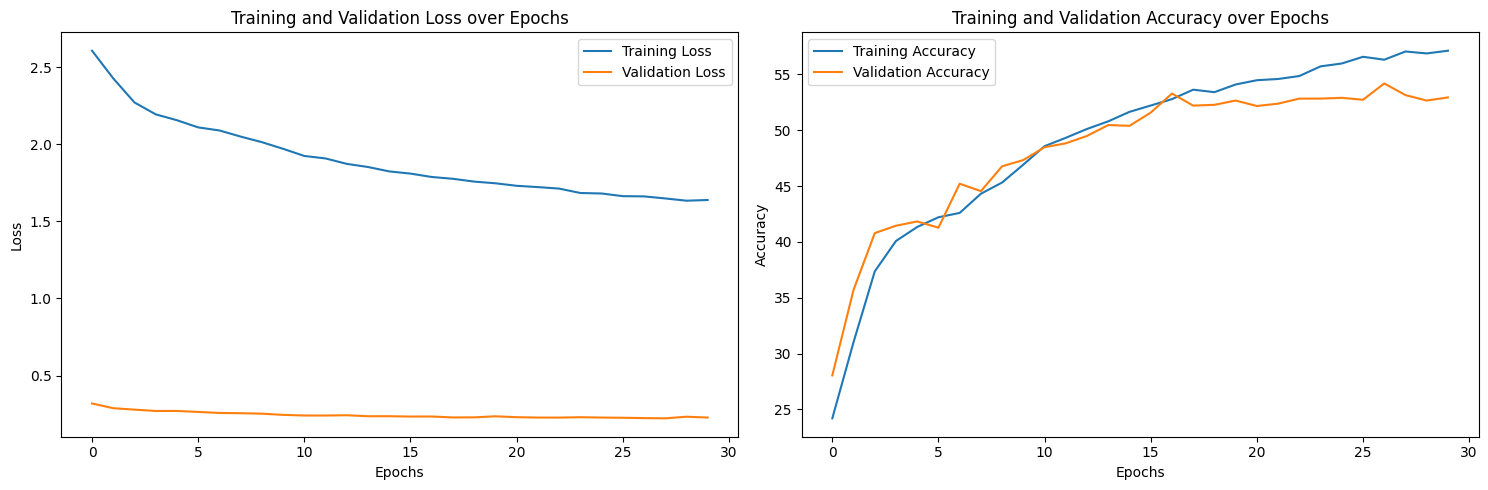

In [335]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()